In [1]:
import re
import os
import math
import string
import time
import sys
import glob
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
from scipy import stats

In [2]:
path = os.getcwd()
testfilesd = glob.glob(path + "/dataset/*.csv")
testfilesk = os.listdir('dataset/')

In [3]:
data_orig = pd.read_csv(testfilesd[0], encoding= 'unicode_escape')
data_df = data_orig.copy()

In [4]:
data_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [5]:
data_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data_df.dropna(inplace=True)

In [7]:
data_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
data_df.isnull().sum().sum()

0

In [9]:
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

In [10]:
data_df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [11]:
data_df['Revenue'] = data_df['Quantity']*data_df['UnitPrice']

In [12]:
data_df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


In [13]:
print('DateLine starts in ' + str(data_df['InvoiceDate'].min()))
print('DateLine ends in ' + str(data_df['InvoiceDate'].max()))

DateLine starts in 2010-12-01 08:26:00
DateLine ends in 2011-12-09 12:50:00


In [14]:
data_df_revenue=  data_df[['InvoiceDate','Revenue']].groupby('InvoiceDate').sum()

In [15]:
data_df_revenue_n = pd.DataFrame({'InvoiceDate':data_df_revenue['Revenue'].keys(), 
                               'Revenue': data_df_revenue['Revenue'].values})

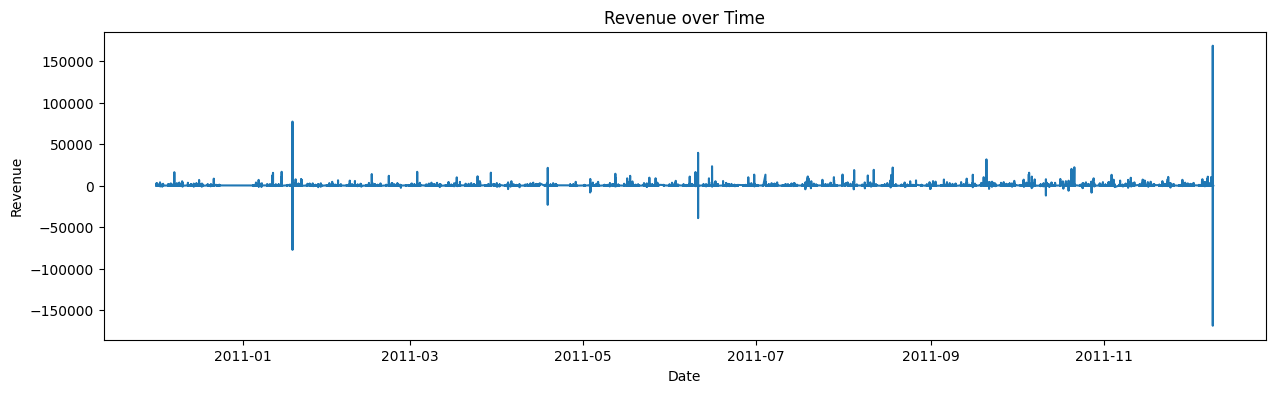

In [16]:
plt.figure(figsize=(15,4))
sns.lineplot(data=data_df_revenue_n,
             x=pd.to_datetime(data_df_revenue_n['InvoiceDate']),
             y=data_df_revenue_n['Revenue'].values)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue over Time')
plt.show()

In [17]:
data_df_revenue_n['InvoiceMonth'] = pd.to_datetime(data_df_revenue_n['InvoiceDate']).dt.day

In [18]:
data_df_revenue_month = data_df_revenue_n[['InvoiceMonth','Revenue']].groupby('InvoiceMonth').sum()

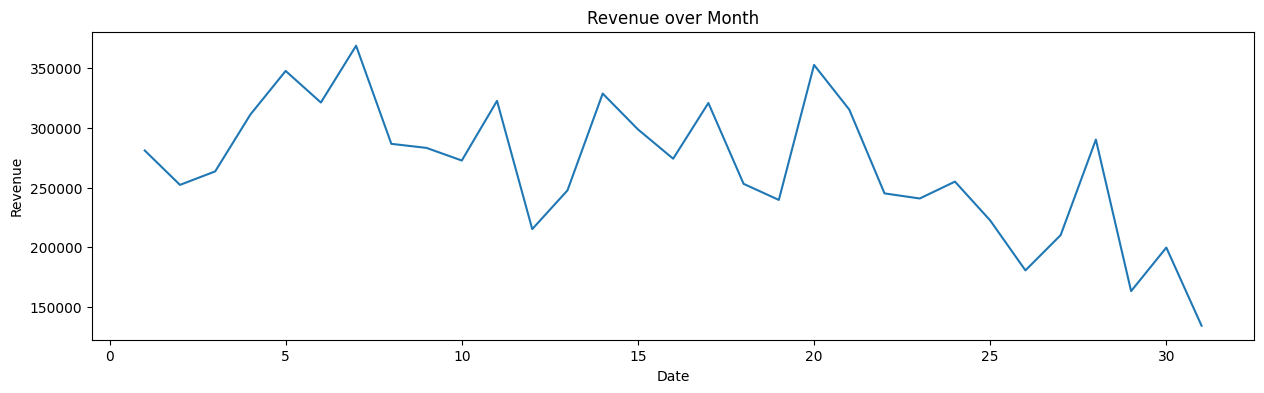

In [19]:
plt.figure(figsize=(15,4))
sns.lineplot(data=data_df_revenue_month,
             x=data_df_revenue_month['Revenue'].keys(),
             y=data_df_revenue_month['Revenue'].values)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue over Month')
plt.show()

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [21]:
data_df['Country'] = le.fit_transform(data_df['Country'])

In [22]:
data_df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,15.3


In [23]:
data_df1 = data_df.copy()

In [24]:
data_df1['Last_transaction']=(data_df1['InvoiceDate'].max()-data_df1['InvoiceDate']).dt.days

In [25]:
last_trans_df = data_df1.groupby('CustomerID')['Last_transaction'].max().reset_index()
revenue_df = data_df.groupby('CustomerID')['Revenue'].mean().reset_index()
last_trans_df_revenue_df = pd.merge(last_trans_df ,revenue_df, on='CustomerID', how='inner')
last_trans_df_revenue_df.head(1)

,CustomerID,Last_transaction,Revenue
0,12346.0,325,0.0


In [26]:
IQR= last_trans_df_revenue_df['Revenue'].quantile(0.75)-last_trans_df_revenue_df['Revenue'].quantile(0.25)
lower_limit= last_trans_df_revenue_df['Revenue'].quantile(0.25) - 1.5*IQR
upper_limit=last_trans_df_revenue_df['Revenue'].quantile(0.75) + 1.5*IQR
k=last_trans_df_revenue_df[last_trans_df_revenue_df['Revenue']>upper_limit]
m=last_trans_df_revenue_df[last_trans_df_revenue_df['Revenue']<lower_limit]
df_outlier=last_trans_df_revenue_df[(last_trans_df_revenue_df['Revenue']<upper_limit) & (last_trans_df_revenue_df['Revenue']>lower_limit)]
print('Data shape before removing outlier',last_trans_df_revenue_df.shape)
print('Data shape after removing outlier',df_outlier.shape)
print('Total number of outlier:',len(k)+len(m))

Data shape before removing outlier (4372, 3)
Data shape after removing outlier (3867, 3)
Total number of outlier: 505


In [27]:
df_outlier.reset_index(drop=True, inplace= True)

In [28]:
df_outlier.head(2)

,CustomerID,Last_transaction,Revenue
0,12346.0,325,0.000000
1,12347.0,366,23.681319


Text(0.5, 1.0, 'Last Transaction and Average Revenue')

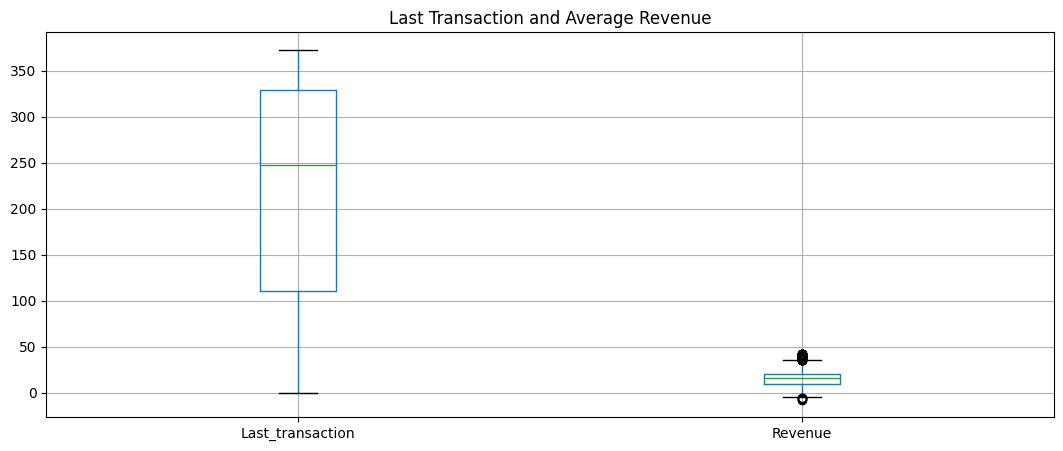

In [29]:
df_outlier.loc[:, ["Last_transaction","Revenue"]].boxplot(figsize=(13,5))
plt.title('Last Transaction and Average Revenue')

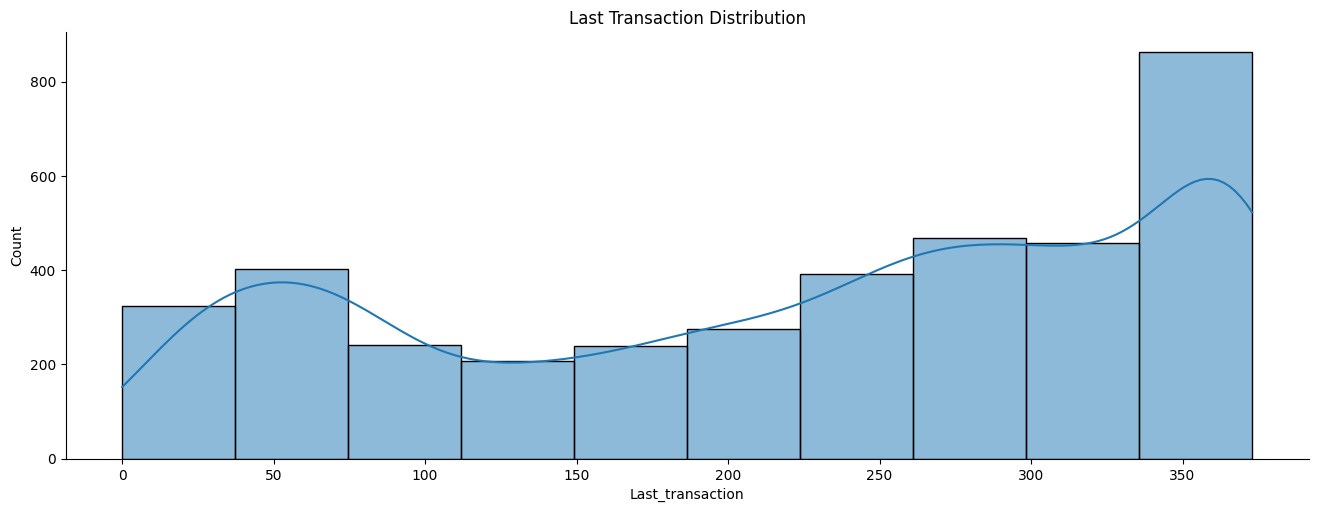

In [30]:
sns.displot(df_outlier['Last_transaction'],bins=10,kde=True)
plt.gcf().set_size_inches(15, 5)
plt.title('Last Transaction Distribution')
plt.show()

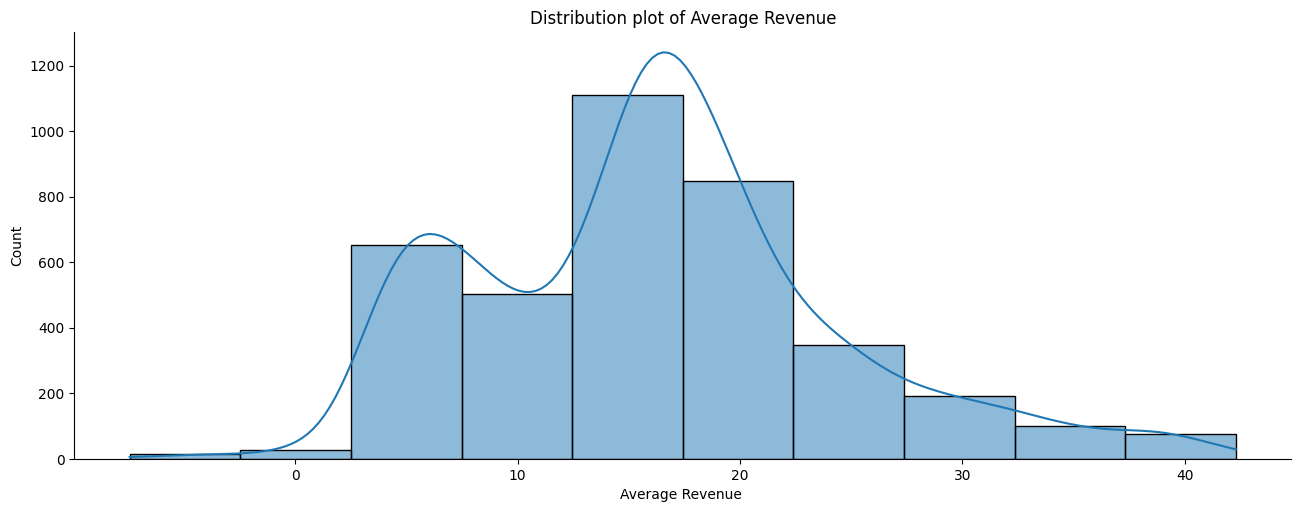

In [31]:
sns.displot(df_outlier['Revenue'],bins=10,kde=True)
plt.gcf().set_size_inches(15, 5)
plt.title('Distribution plot of Average Revenue')
plt.xlabel('Average Revenue ')
plt.show()

In [32]:
new_df = df_outlier.copy()

<AxesSubplot: >

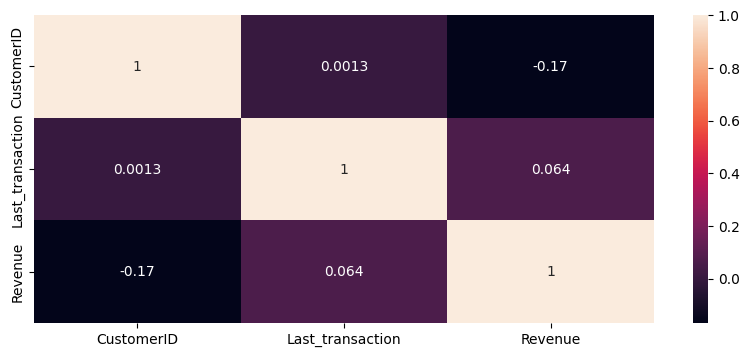

In [33]:
plt.figure(figsize=(10,4))
sns.heatmap(new_df.corr(), annot=True)

In [34]:
new_df = new_df[['Last_transaction', 'Revenue']]

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [36]:
new_df2=scaler.fit_transform(new_df)
scaled_df = pd.DataFrame(new_df2)
scaled_df.columns=new_df.columns

In [37]:
scaled_df.head(2)

,Last_transaction,Revenue
0,0.871314,0.149749
1,0.981233,0.625755


In [38]:
scaled_df['CustomerID'] = df_outlier['CustomerID']
new_df['CustomerID'] = df_outlier['CustomerID']

In [39]:
scaled_df.head(1)

,Last_transaction,Revenue,CustomerID
0,0.871314,0.149749,12346.0


## KMeans: Centroid-based Clustering

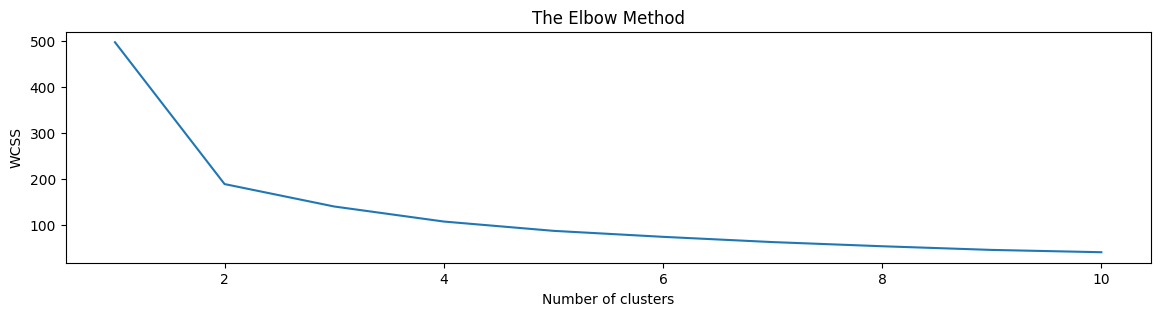

In [40]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_df2)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(14,3))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

## KMeans Elbow

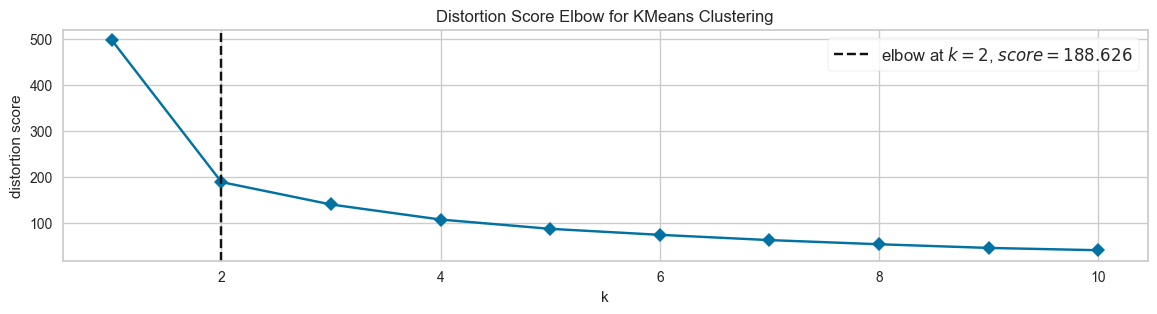

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
plt.figure(figsize=(14,3))
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(new_df2)  
visualizer.show() 

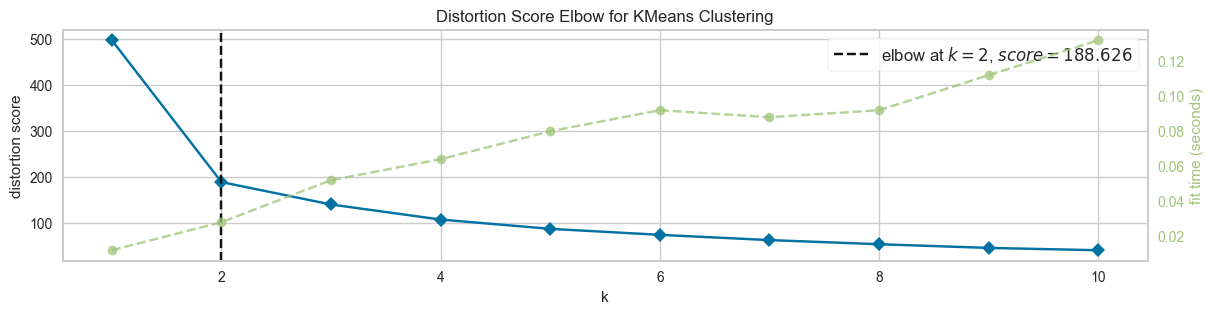

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
model = KMeans()
plt.figure(figsize=(14,3))
visualizer = KElbowVisualizer(model, k=(1,11), timings= True)
visualizer.fit(new_df2)  
visualizer.show() 

## KMeans: Silhouette

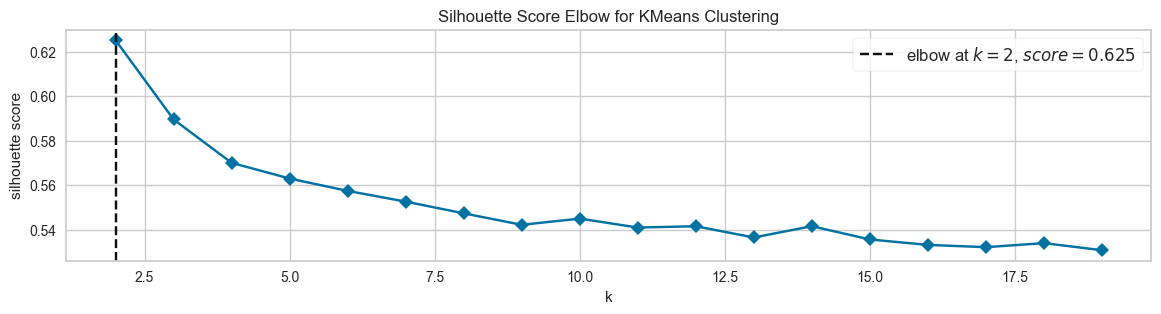

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [43]:
model = KMeans()
plt.figure(figsize=(14,3))
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= False)
visualizer.fit(scaled_df)       
visualizer.show() 

In [44]:
from sklearn.metrics import silhouette_score

In [45]:
k_model = KMeans(n_clusters=5, random_state=42)
k_model.fit_predict(new_df2)
score = silhouette_score(new_df2, k_model.labels_, metric='euclidean')
print('Silhouetter Average Score: %.3f' % score)

Silhouetter Average Score: 0.365


In [46]:
y_predicted = k_model.fit_predict(new_df2)

In [47]:
new_df['clusters']= y_predicted
new_df.head(2)

,Last_transaction,Revenue,CustomerID,clusters
0,325,0.000000,12346.0,0
1,366,23.681319,12347.0,3


In [48]:
new_df['clusters'].value_counts()

0    1116
2     995
1     673
3     568
4     515
Name: clusters, dtype: int64

Group1: Red / Group 2: Yellow / Group 3: Green/ Group 4: Blue / Group 5: Purple


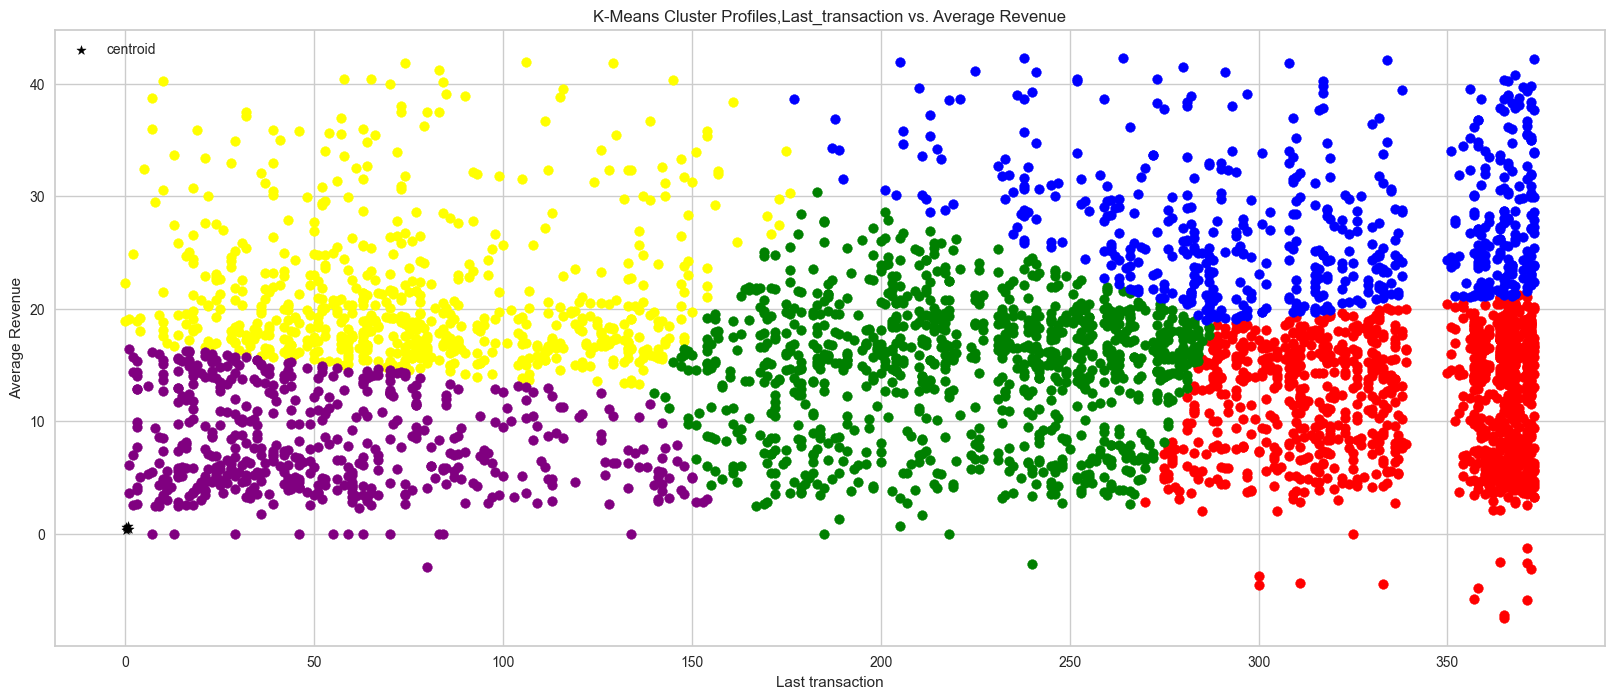

In [49]:
df0 = new_df[new_df.clusters==0]
df1 = new_df[new_df.clusters==1]
df2 = new_df[new_df.clusters==2]
df3 = new_df[new_df.clusters==3]
df4 = new_df[new_df.clusters==4]

plt.figure(figsize=(20,8))
plt.scatter(df0.Last_transaction,df0['Revenue'],color='red')
plt.scatter(df1.Last_transaction,df1['Revenue'],color='yellow')
plt.scatter(df2.Last_transaction,df2['Revenue'],color='green')
plt.scatter(df3.Last_transaction,df3['Revenue'],color='blue')
plt.scatter(df4.Last_transaction,df4['Revenue'],color='purple')
print("Group1: Red / Group 2: Yellow / Group 3: Green/ Group 4: Blue / Group 5: Purple")
plt.scatter(k_model.cluster_centers_[:,0],k_model.cluster_centers_[:,1],color='black',marker='*',label='centroid')
plt.legend()
plt.xlabel('Last transaction')
plt.ylabel('Average Revenue')
plt.title('K-Means Cluster Profiles,Last_transaction vs. Average Revenue')
plt.show()

## Hierarchical Clustering

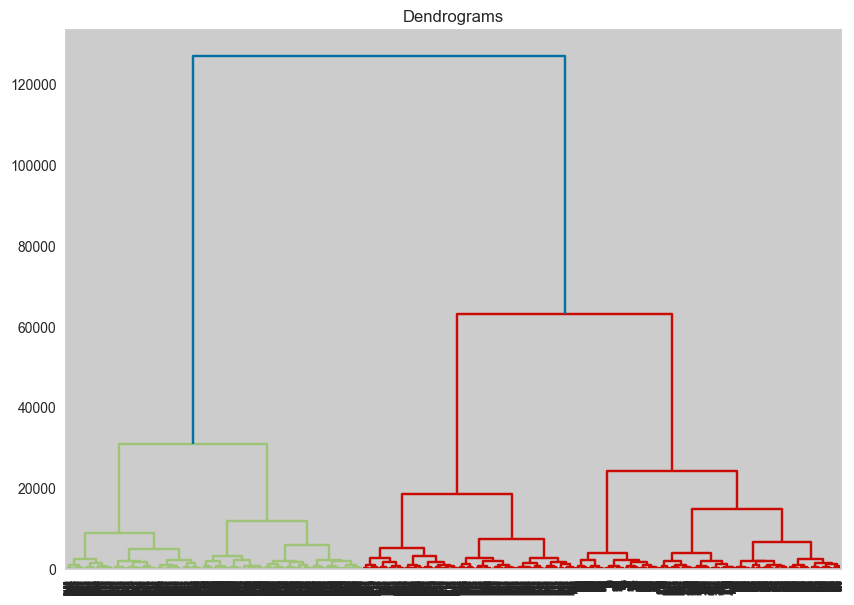

In [50]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(new_df, method='ward'))

In [51]:
new_df3 = data_df.copy()

In [52]:
new_df3.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,35,15.3


In [53]:
new_df3 = new_df3[['Quantity', 'UnitPrice', 'CustomerID', 'Country']].set_index('CustomerID')

In [54]:
new_df3.head(2)

,Quantity,UnitPrice,Country
CustomerID,,,
17850.0,6,2.55,35
17850.0,6,3.39,35


In [55]:
c1 = pd.merge(new_df3,new_df.reset_index()[['clusters','CustomerID']], on='CustomerID')

In [56]:
print("Quantity and UnitPrice by Clusters")
for i in range(0, 5):
    c1 = pd.merge(new_df3,new_df.reset_index()[['Last_transaction', 'Revenue', 'clusters','CustomerID']], on='CustomerID')
    c1 = c1[c1.clusters == i]
    print("Cluster: "+ str(i))
    print('Quantity: ', round(c1.mean()['Quantity'],3))
    print('UnitPrice:', round(c1.mean()['UnitPrice'],3))
    print('Last_transaction: ', round(c1.mean()['Last_transaction'],3))
    print('Average Revenue:', round(c1.mean()['Revenue'],3))
    print('------')

Quantity and UnitPrice by Clusters
Cluster: 0
Quantity:  6.286
UnitPrice: 2.902
Last_transaction:  349.054
Average Revenue: 10.364
------
Cluster: 1
Quantity:  11.66
UnitPrice: 3.907
Last_transaction:  85.875
Average Revenue: 19.791
------
Cluster: 2
Quantity:  8.133
UnitPrice: 3.147
Last_transaction:  228.405
Average Revenue: 13.176
------
Cluster: 3
Quantity:  15.312
UnitPrice: 3.925
Last_transaction:  337.893
Average Revenue: 26.18
------
Cluster: 4
Quantity:  4.826
UnitPrice: 3.211
Last_transaction:  70.218
Average Revenue: 7.142
------


## Conclusion
- Group1: Customer who spend average from 0 to 20, and their last order is between 7 months to 12 months
- Group2: Customer who spend average from 17 to 40, and their last order is within 4 months
- Group3: Customer who spend average from 0 to 30, and their last order is between 5 months to 8 months
- Group4: Customer who spend average from 20 to 40, and their last order is between 7 months to 12 months
- Group5: Customer who spend average from 0 to 17, and their last order is within 4 months.

I think both Group 2 and 5 is the important segment of the company because they would come back to e-commerce site for product. Group 2 would be most important because they spend relatively high amount to buy the product in this company. 